<a href="https://colab.research.google.com/github/PIRomanCod/DataSciense_HW/blob/main/HW_11_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# В якості домашнього завдання вам пропонується створити рекурентну нейронну мережу за допомогою механізмів Keras, яка буде класифікувати рецензії із датасету imdb.

На відміну від прикладу в модулі 9 ми використаємо рекурентну нейронну мережу. Поекспериментуйте з будовою мережі - RNN, LSTM, двостороння та глибока.

Порівняйте результати та зробіть висновки.

## Імпорти

In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=5998df68a05f5dcd4b2f5142857566093b419fd7f512072dd81c84e5a391d47a
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [2]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, SimpleRNN, GRU, LSTM, Bidirectional
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, SGD
from keras.metrics import Accuracy
from keras.models import load_model

from sklearn.metrics import confusion_matrix

import wandb
from wandb.keras import WandbMetricsLogger


## Встановлення констант та налаштування

In [3]:
max_features = 10000  # кількість слів, що розглядаються як особливості
maxlen = 500  # обмеження кількості слів в тексті
batch_size = 128
n_epochs = 15
lr = 0.001

In [4]:
best_of_models = {}

In [5]:
wandb.init(project="HW_11_Simple_RNN", config={"lr": lr, "n_epochs": n_epochs, "batch_size": batch_size})

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [6]:
path = "/content/drive/MyDrive/Colab_Notebooks/HW_11_data"

In [7]:
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    os.environ["TF_DETERMINISTIC_OPS"] = "true"


set_seed(42)

In [8]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=max_features)

17464789/17464789 [==============================] - 1s 0us/step


In [9]:
# Подивимося розміри наборів даних
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((25000,), (25000,), (25000,), (25000,))

In [10]:
# Передпроцесинг послідовних даних:
# Застосування заздалегідь обраної максимальної довжини до послідовних даних тренувального та тестового наборів

input_train = pad_sequences(train_data, maxlen=maxlen)
input_test = pad_sequences(test_data, maxlen=maxlen)

In [11]:
# Ще раз подивимося на розміри ф'ючерів, що будуть подаватися до моделі
input_train.shape, input_test.shape

((25000, 500), (25000, 500))

## Словник для трансформацій до людскої мови

In [12]:
word_index = imdb.get_word_index()

1641221/1641221 [==============================] - 1s 0us/step


### Подивимося зразок даних, що будуть подані до мережі у оригінальному вигляді

In [13]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [14]:
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}

### А тепер у вигляді речення

In [15]:
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

## Побудова простої моделі RNN:

In [ ]:
model_Simple_RNN = Sequential()
# Створення порожньої моделі Sequential

# Додавання Embedding шару для перетворення слів в вектори фіксованої довжини
model_Simple_RNN.add(Embedding(max_features, 32))
# Параметри: кількість слів для розгляду як особливості та розмір вектора, що представляє кожне слово

# Додавання SimpleRNN шару з 32 вузлами
model_Simple_RNN.add(SimpleRNN(32))
# Параметр: кількість вузлів (розмір прихованого стану)

# Додавання Dense шару з одним вузлом та активацією sigmoid
model_Simple_RNN.add(Dense(1, activation='sigmoid'))
# Параметри: кількість вузлів (вихідний розмір) та функція активації (sigmoid для бінарної класифікації)

In [ ]:
# Додамо колбек EarlyStopping, щоб зупинити навчання, якщо точність не покращується протягом певної кількості епох
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

# Додамо колбек ModelCheckpoint, щоб зберегти найкращу модель за кожним епохом
model_checkpoint_callback = ModelCheckpoint(path+'/HW_11_best_model_RNN_Simple.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)



In [ ]:
callbacks=[early_stopping_callback, model_checkpoint_callback, WandbMetricsLogger()]

In [ ]:
model_Simple_RNN.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model_Simple_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_Simple_RNN.fit(
    input_train, train_labels,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=0.3,
    callbacks=callbacks)
# Запускаємо навчання моделі на тренувальних даних з розбиттям на тренувальну та валідаційну підмножини

Epoch 1/15
137/137 [==============================] - ETA: 0s - loss: 0.6759 - accuracy: 0.5747
Epoch 1: val_accuracy improved from -inf to 0.76040, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_RNN_Simple.h5
137/137 [==============================] - 96s 656ms/step - loss: 0.6759 - accuracy: 0.5747 - val_loss: 0.5680 - val_accuracy: 0.7604
Epoch 2/15
137/137 [==============================] - ETA: 0s - loss: 0.5227 - accuracy: 0.7713
Epoch 2: val_accuracy improved from 0.76040 to 0.78827, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_RNN_Simple.h5
137/137 [==============================] - 76s 558ms/step - loss: 0.5227 - accuracy: 0.7713 - val_loss: 0.4623 - val_accuracy: 0.7883
Epoch 3/15
137/137 [==============================] - ETA: 0s - loss: 0.2762 - accuracy: 0.8902
Epoch 3: val_accuracy improved from 0.78827 to 0.81707, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_RN

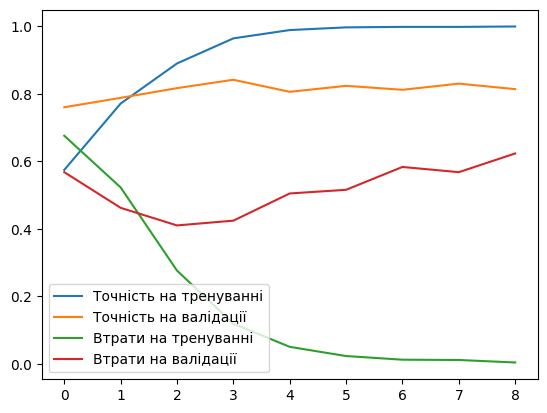

In [ ]:
# Графіки для точності та втрат
plt.plot(history.history['accuracy'], label='Точність на тренуванні')
plt.plot(history.history['val_accuracy'], label='Точність на валідації')
plt.plot(history.history['loss'], label='Втрати на тренуванні')
plt.plot(history.history['val_loss'], label='Втрати на валідації')
plt.legend()
plt.show()

In [16]:
# Завантаження кращої збереженої моделі
best_model_SimpleRNN = load_model(path+'/HW_11_best_model_RNN_Simple.h5')

# Тестування на тестових даних
test_loss, test_accuracy = best_model_SimpleRNN.evaluate(input_test, test_labels)
best_of_models.update({"best_model_SimpleRNN": test_accuracy})

print(f"Втрати на тестовому наборі: {test_loss:.4f}")
print(f"Точність на тестовому наборі: {test_accuracy:.4f}")

782/782 [==============================] - 49s 56ms/step - loss: 0.4473 - accuracy: 0.8310
Втрати на тестовому наборі: 0.4473
Точність на тестовому наборі: 0.8310


In [17]:
# Прогнозування з використанням навченої моделі:

predictions = best_model_SimpleRNN.predict(input_test)

# Для отримання зрозумілішого вигляду прогнозів, їх можна перетворити в бінарний формат:
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

# Для порівняння можна вивести деякі прогнозовані значення поряд з фактичними значеннями
for i in range(10):
    print(f"Прогнозоване: {binary_predictions[i]}, Фактичне: {test_labels[i]}")

# Додатковий крок: Оцінка моделі
# Це дасть загальну точність моделі на тестових даних
# test_loss, test_acc = best_model_SimpleRNN.evaluate(input_test, test_labels)
# print('Test Loss: {}'.format(test_loss))
# print('Test Accuracy: {}'.format(test_acc))

782/782 [==============================] - 47s 60ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1


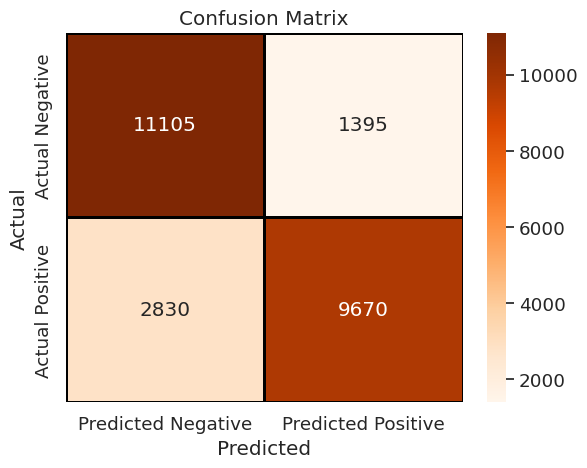

In [18]:
# Побудуємо confusion_matrix
confusion_mat = confusion_matrix(test_labels, binary_predictions)


# Використання Seaborn для візуалізації теплової карти
sns.set(font_scale=1.2)
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Oranges", linewidths=1, linecolor="black",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [19]:
wandb.finish()

##Суб висновок: - валідаційні дані проходять з наступними показниками. Точність - 84.8% на валідації, час 10 хвилин, на тесті - 83.9%. n_epoch=15; lr=0,001; batch_size=128 Trainable params: 322,113

## Побудова  GRU моделі

In [ ]:
model_RNN_GRU = Sequential()
# Створення порожньої моделі Sequential

# Додавання Embedding шару для перетворення слів в вектори фіксованої довжини
model_RNN_GRU.add(Embedding(max_features, 32))
# Параметри: кількість слів для розгляду як особливості та розмір вектора, що представляє кожне слово

# Додавання GRU шару з 32 вузлами
model_RNN_GRU.add(GRU(32))
# Параметр: кількість вузлів (розмір прихованого стану)

# Додавання Dense шару з одним вузлом та активацією sigmoid
model_RNN_GRU.add(Dense(1, activation='sigmoid'))
# Параметри: кількість вузлів (вихідний розмір) та функція активації (sigmoid для бінарної класифікації)

In [ ]:
# Замінимо колбек ModelCheckpoint, щоб зберегти найкращу модель за кожним епохом
model_checkpoint_callback = ModelCheckpoint(path+'/HW_11_best_model_RNN_GRU.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

In [ ]:
# Додамо новий монітор
wandb.init(project="HW_11_RNN_GRU", config={"lr": lr, "n_epochs": n_epochs, "batch_size": batch_size})

wandb: Currently logged in as: 4751413. Use `wandb login --relogin` to force relogin


In [ ]:
callbacks=[early_stopping_callback, model_checkpoint_callback, WandbMetricsLogger()]

In [ ]:
model_RNN_GRU.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model_RNN_GRU.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 326,369
Trainable params: 326,369
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_RNN_GRU = model_RNN_GRU.fit(
    input_train, train_labels,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=0.3,
    callbacks=callbacks)
# Запускаємо навчання моделі на тренувальних даних з розбиттям на тренувальну та валідаційну підмножини

Epoch 1/15
136/137 [============================>.] - ETA: 0s - loss: 0.5746 - accuracy: 0.6779
Epoch 1: val_accuracy improved from -inf to 0.82613, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_RNN_GRU.h5
137/137 [==============================] - 9s 39ms/step - loss: 0.5733 - accuracy: 0.6789 - val_loss: 0.3930 - val_accuracy: 0.8261
Epoch 2/15
137/137 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.8773
Epoch 2: val_accuracy improved from 0.82613 to 0.86907, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_RNN_GRU.h5
137/137 [==============================] - 4s 26ms/step - loss: 0.2969 - accuracy: 0.8773 - val_loss: 0.3163 - val_accuracy: 0.8691
Epoch 3/15
137/137 [==============================] - ETA: 0s - loss: 0.2021 - accuracy: 0.9253
Epoch 3: val_accuracy improved from 0.86907 to 0.86933, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_RNN_GRU.h5
1

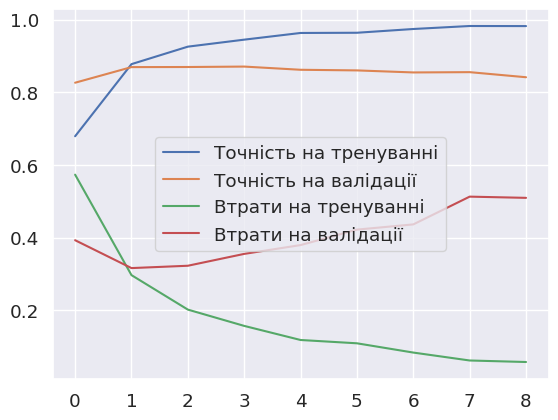

In [ ]:
# Графіки для точності та втрат
plt.plot(history_RNN_GRU.history['accuracy'], label='Точність на тренуванні')
plt.plot(history_RNN_GRU.history['val_accuracy'], label='Точність на валідації')
plt.plot(history_RNN_GRU.history['loss'], label='Втрати на тренуванні')
plt.plot(history_RNN_GRU.history['val_loss'], label='Втрати на валідації')
plt.legend()
plt.show()

In [20]:
# Завантаження кращої збереженої моделі
best_model_RNN_GRU = load_model(path+'/HW_11_best_model_RNN_GRU.h5')

# Тестування на тестових даних
test_loss, test_accuracy = best_model_RNN_GRU.evaluate(input_test, test_labels)
best_of_models.update({"best_model_RNN_GRU": test_accuracy})

print(f"Втрати на тестовому наборі: {test_loss:.4f}")
print(f"Точність на тестовому наборі: {test_accuracy:.4f}")

782/782 [==============================] - 7s 8ms/step - loss: 0.3840 - accuracy: 0.8597
Втрати на тестовому наборі: 0.3840
Точність на тестовому наборі: 0.8597


In [21]:
# Прогнозування з використанням навченої моделі:

predictions = best_model_RNN_GRU.predict(input_test)

# Для отримання зрозумілішого вигляду прогнозів, їх можна перетворити в бінарний формат:
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

# Для порівняння можна вивести деякі прогнозовані значення поряд з фактичними значеннями
for i in range(10):
    print(f"Прогнозоване: {binary_predictions[i]}, Фактичне: {test_labels[i]}")

782/782 [==============================] - 7s 8ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1


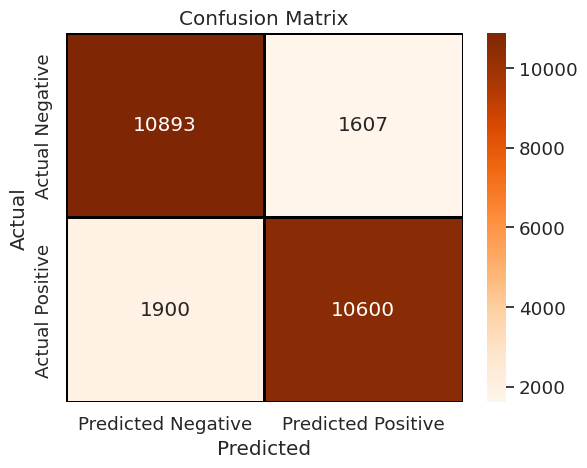

In [22]:
# Побудуємо confusion_matrix
confusion_mat = confusion_matrix(test_labels, binary_predictions)


# Використання Seaborn для візуалізації теплової карти
sns.set(font_scale=1.2)
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Oranges", linewidths=1, linecolor="black",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [23]:
wandb.finish()

##Суб висновок: - валідаційні дані проходять з наступними показниками. Точність - 86.5% на валідації, час 25 хвилин, на тесті - 85.1%. n_epoch=15; lr=0,001; batch_size=128 Trainable params:326,369

## Побудова моделі LSTM

In [24]:
model_RNN_LSTM = Sequential()
# Створення порожньої моделі Sequential

# Додавання Embedding шару для перетворення слів в вектори фіксованої довжини
model_RNN_LSTM.add(Embedding(max_features, 32))
# Параметри: кількість слів для розгляду як особливості та розмір вектора, що представляє кожне слово

# Додавання LSTM шару з 32 вузлами
model_RNN_LSTM.add(LSTM(32))
# Параметр: кількість вузлів (розмір прихованого стану)

# Додавання Dense шару з одним вузлом та активацією sigmoid
model_RNN_LSTM.add(Dense(1, activation='sigmoid'))
# Параметри: кількість вузлів (вихідний розмір) та функція активації (sigmoid для бінарної класифікації)

In [ ]:
# Замінимо колбек ModelCheckpoint, щоб зберегти найкращу модель за кожним епохом
model_checkpoint_callback = ModelCheckpoint(path+'/HW_11_best_model_RNN_LSTM.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

In [ ]:
# Додамо новий монітор
wandb.init(project="HW_11_RNN_LSTM", config={"lr": lr, "n_epochs": n_epochs, "batch_size": batch_size})

In [ ]:
callbacks=[early_stopping_callback, model_checkpoint_callback, WandbMetricsLogger()]

In [ ]:
model_RNN_LSTM.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model_RNN_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_RNN_LSTM = model_RNN_LSTM.fit(
    input_train, train_labels,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=0.3,
    callbacks=callbacks)
# Запускаємо навчання моделі на тренувальних даних з розбиттям на тренувальну та валідаційну підмножини

Epoch 1/15
136/137 [============================>.] - ETA: 0s - loss: 0.5155 - accuracy: 0.7419
Epoch 1: val_accuracy improved from -inf to 0.85973, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_RNN_LSTM.h5
137/137 [==============================] - 7s 36ms/step - loss: 0.5144 - accuracy: 0.7427 - val_loss: 0.3475 - val_accuracy: 0.8597
Epoch 2/15
136/137 [============================>.] - ETA: 0s - loss: 0.2598 - accuracy: 0.8995
Epoch 2: val_accuracy improved from 0.85973 to 0.87693, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_RNN_LSTM.h5
137/137 [==============================] - 4s 32ms/step - loss: 0.2598 - accuracy: 0.8993 - val_loss: 0.2999 - val_accuracy: 0.8769
Epoch 3/15
136/137 [============================>.] - ETA: 0s - loss: 0.1785 - accuracy: 0.9378
Epoch 3: val_accuracy improved from 0.87693 to 0.88200, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_RNN_LSTM.h

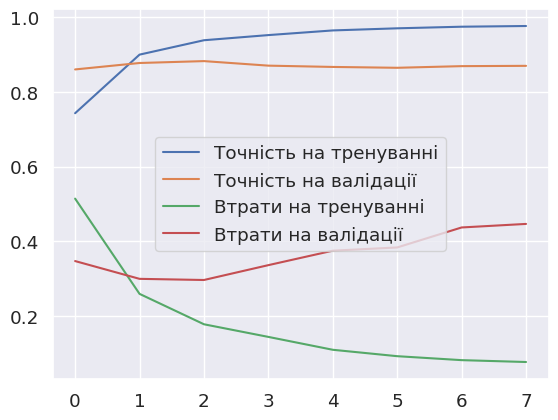

In [ ]:
# Графіки для точності та втрат
plt.plot(history_RNN_LSTM.history['accuracy'], label='Точність на тренуванні')
plt.plot(history_RNN_LSTM.history['val_accuracy'], label='Точність на валідації')
plt.plot(history_RNN_LSTM.history['loss'], label='Втрати на тренуванні')
plt.plot(history_RNN_LSTM.history['val_loss'], label='Втрати на валідації')
plt.legend()
plt.show()

In [25]:
# Завантаження кращої збереженої моделі
best_model_RNN_LSTM = load_model(path+'/HW_11_best_model_RNN_LSTM.h5')

# Тестування на тестових даних
test_loss, test_accuracy = best_model_RNN_LSTM.evaluate(input_test, test_labels)
best_of_models.update({"best_model_RNN_LSTM": test_accuracy})

print(f"Втрати на тестовому наборі: {test_loss:.4f}")
print(f"Точність на тестовому наборі: {test_accuracy:.4f}")

782/782 [==============================] - 11s 13ms/step - loss: 0.3156 - accuracy: 0.8722
Втрати на тестовому наборі: 0.3156
Точність на тестовому наборі: 0.8722


In [26]:
# Прогнозування з використанням навченої моделі:

predictions = best_model_RNN_LSTM.predict(input_test)

# Для отримання зрозумілішого вигляду прогнозів, їх можна перетворити в бінарний формат:
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

# Для порівняння можна вивести деякі прогнозовані значення поряд з фактичними значеннями
for i in range(10):
    print(f"Прогнозоване: {binary_predictions[i]}, Фактичне: {test_labels[i]}")

782/782 [==============================] - 5s 7ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1


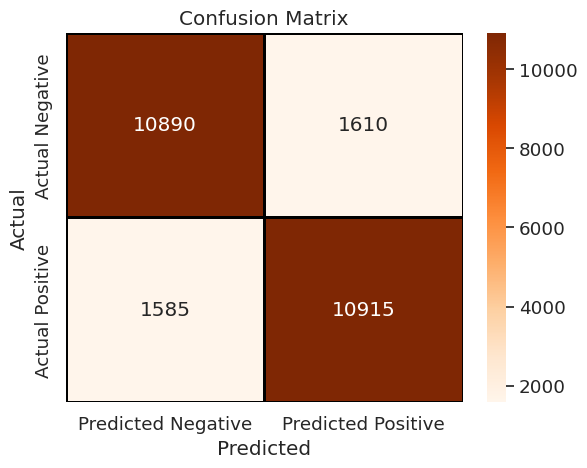

In [27]:
# Побудуємо confusion_matrix
confusion_mat = confusion_matrix(test_labels, binary_predictions)


# Використання Seaborn для візуалізації теплової карти
sns.set(font_scale=1.2)
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Oranges", linewidths=1, linecolor="black",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [28]:
wandb.finish()

## Суб висновок: - валідаційні дані проходять з наступними показниками. Точність - 88.2% на валідації, час 20 хвилин, на тесті - 87.2%. n_epoch=15; lr=0,001; batch_size=128 Trainable params: 328,353

## Побудова моделі BRNN LSTM:

In [29]:
model_BRNN = Sequential()
# Створення порожньої моделі Sequential

# Додавання Embedding шару для перетворення слів в вектори фіксованої довжини
model_BRNN.add(Embedding(max_features, 32))
# Параметри: кількість слів для розгляду як особливості та розмір вектора, що представляє кожне слово

# Додавання Bidirectional LSTM шару з 32 вузлами
model_BRNN.add(Bidirectional(LSTM(32)))
# Параметр: кількість вузлів (розмір прихованого стану)

# Додавання Dense шару з одним вузлом та активацією sigmoid
model_BRNN.add(Dense(1, activation='sigmoid'))
# Параметри: кількість вузлів (вихідний розмір) та функція активації (sigmoid для бінарної класифікації)

In [ ]:
# Замінимо колбек ModelCheckpoint, щоб зберегти найкращу модель за кожним епохом
model_checkpoint_callback = ModelCheckpoint(path+'/HW_11_best_model_BRNN.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

In [ ]:
# Додамо новий монітор
wandb.init(project="HW_11_BRNN", config={"lr": lr, "n_epochs": n_epochs, "batch_size": batch_size})

In [ ]:
callbacks=[early_stopping_callback, model_checkpoint_callback, WandbMetricsLogger()]

In [ ]:
model_BRNN.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model_BRNN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 336,705
Trainable params: 336,705
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_BRNN = model_BRNN.fit(
    input_train, train_labels,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=0.3,
    callbacks=callbacks)
# Запускаємо навчання моделі на тренувальних даних з розбиттям на тренувальну та валідаційну підмножини

Epoch 1/15
136/137 [============================>.] - ETA: 0s - loss: 0.5504 - accuracy: 0.7132
Epoch 1: val_accuracy improved from -inf to 0.84293, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_BRNN.h5
137/137 [==============================] - 12s 56ms/step - loss: 0.5492 - accuracy: 0.7141 - val_loss: 0.3717 - val_accuracy: 0.8429
Epoch 2/15
136/137 [============================>.] - ETA: 0s - loss: 0.2911 - accuracy: 0.8863
Epoch 2: val_accuracy improved from 0.84293 to 0.87187, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_BRNN.h5
137/137 [==============================] - 7s 49ms/step - loss: 0.2911 - accuracy: 0.8863 - val_loss: 0.3072 - val_accuracy: 0.8719
Epoch 3/15
137/137 [==============================] - ETA: 0s - loss: 0.2051 - accuracy: 0.9274
Epoch 3: val_accuracy improved from 0.87187 to 0.88520, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_BRNN.h5
137/137 [

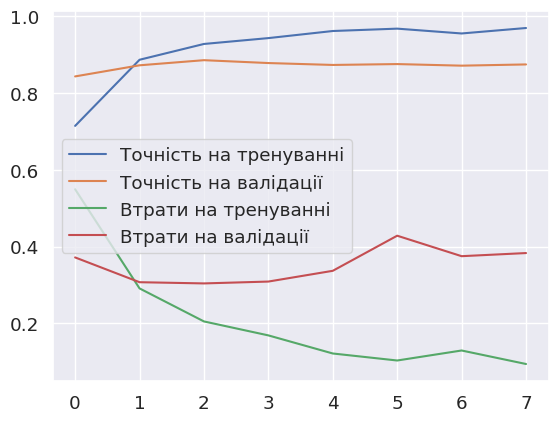

In [ ]:
# Графіки для точності та втрат
plt.plot(history_BRNN.history['accuracy'], label='Точність на тренуванні')
plt.plot(history_BRNN.history['val_accuracy'], label='Точність на валідації')
plt.plot(history_BRNN.history['loss'], label='Втрати на тренуванні')
plt.plot(history_BRNN.history['val_loss'], label='Втрати на валідації')
plt.legend()
plt.show()

In [30]:
# Завантаження кращої збереженої моделі
best_model_BRNN = load_model(path+'/HW_11_best_model_BRNN.h5')

# Тестування на тестових даних
test_loss, test_accuracy = best_model_BRNN.evaluate(input_test, test_labels)
best_of_models.update({"best_model_BRNN": test_accuracy})

print(f"Втрати на тестовому наборі: {test_loss:.4f}")
print(f"Точність на тестовому наборі: {test_accuracy:.4f}")

782/782 [==============================] - 13s 15ms/step - loss: 0.3380 - accuracy: 0.8714
Втрати на тестовому наборі: 0.3380
Точність на тестовому наборі: 0.8714


In [31]:
# Прогнозування з використанням навченої моделі:

predictions = best_model_BRNN.predict(input_test)

# Для отримання зрозумілішого вигляду прогнозів, їх можна перетворити в бінарний формат:
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

# Для порівняння можна вивести деякі прогнозовані значення поряд з фактичними значеннями
for i in range(10):
    print(f"Прогнозоване: {binary_predictions[i]}, Фактичне: {test_labels[i]}")

782/782 [==============================] - 11s 14ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1


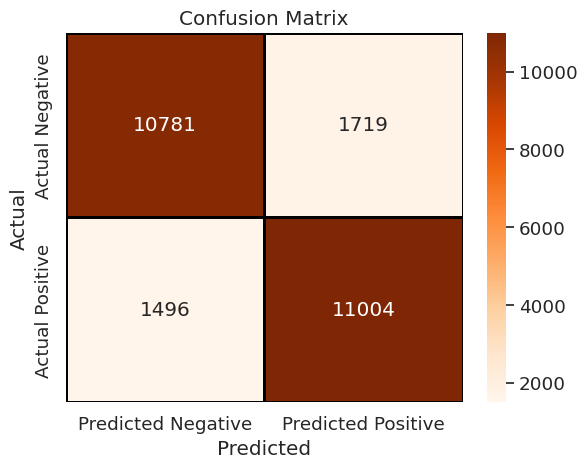

In [32]:
# Побудуємо confusion_matrix
confusion_mat = confusion_matrix(test_labels, binary_predictions)


# Використання Seaborn для візуалізації теплової карти
sns.set(font_scale=1.2)
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Oranges", linewidths=1, linecolor="black",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [33]:
wandb.finish()

## Суб висновок: - валідаційні дані проходять з наступними показниками. Точність - 88.5% на валідації, час 40 хвилин, на тесті - 87.1%. n_epoch=15; lr=0,001; batch_size=128 Trainable params: 336,705



## Deep BRNN

In [34]:
model_Deep_BRNN = Sequential()
# Створення порожньої моделі Sequential

# Додавання Embedding шару для перетворення слів в вектори фіксованої довжини
model_Deep_BRNN.add(Embedding(max_features, 32))
# Параметри: кількість слів для розгляду як особливості та розмір вектора, що представляє кожне слово

# Додавання декількох Bidirectional LSTM шару з 32 вузлами
model_Deep_BRNN.add(Bidirectional(LSTM(32, return_sequences=True)))
model_Deep_BRNN.add(Bidirectional(LSTM(32)))
# Параметр: кількість вузлів (розмір прихованого стану) і return_sequences=True для першого шару, щоб надати послідовність як вхід на наступний шар

# Додавання Dense шару з одним вузлом та активацією sigmoid
model_Deep_BRNN.add(Dense(1, activation='sigmoid'))
# Параметри: кількість вузлів (вихідний розмір) та функція активації (sigmoid для бінарної класифікації)

In [35]:
# Замінимо колбек ModelCheckpoint, щоб зберегти найкращу модель за кожним епохом
model_checkpoint_callback = ModelCheckpoint(path+'/HW_11_best_model_Deep_BRNN.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

In [ ]:
# Додамо новий монітор
wandb.init(project="HW_11_Deep_BRNN", config={"lr": lr, "n_epochs": n_epochs, "batch_size": batch_size})

In [ ]:
callbacks=[early_stopping_callback, model_checkpoint_callback, WandbMetricsLogger()]

In [ ]:
model_Deep_BRNN.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model_Deep_BRNN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 32)          320000    
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 64)         16640     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 361,537
Trainable params: 361,537
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_Deep_BRNN = model_Deep_BRNN.fit(
    input_train, train_labels,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=0.3,
    callbacks=callbacks)
# Запускаємо навчання моделі на тренувальних даних з розбиттям на тренувальну та валідаційну підмножини

Epoch 1/15
137/137 [==============================] - ETA: 0s - loss: 0.5406 - accuracy: 0.7165
Epoch 1: val_accuracy improved from -inf to 0.82920, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_Deep_BRNN.h5
137/137 [==============================] - 20s 105ms/step - loss: 0.5406 - accuracy: 0.7165 - val_loss: 0.4072 - val_accuracy: 0.8292
Epoch 2/15
137/137 [==============================] - ETA: 0s - loss: 0.3116 - accuracy: 0.8782
Epoch 2: val_accuracy improved from 0.82920 to 0.85920, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_Deep_BRNN.h5
137/137 [==============================] - 19s 138ms/step - loss: 0.3116 - accuracy: 0.8782 - val_loss: 0.3375 - val_accuracy: 0.8592
Epoch 3/15
137/137 [==============================] - ETA: 0s - loss: 0.2024 - accuracy: 0.9298
Epoch 3: val_accuracy improved from 0.85920 to 0.87440, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_Deep

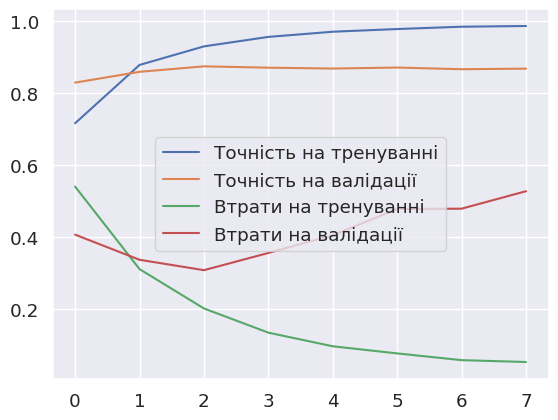

In [ ]:
# Графіки для точності та втрат
plt.plot(history_Deep_BRNN.history['accuracy'], label='Точність на тренуванні')
plt.plot(history_Deep_BRNN.history['val_accuracy'], label='Точність на валідації')
plt.plot(history_Deep_BRNN.history['loss'], label='Втрати на тренуванні')
plt.plot(history_Deep_BRNN.history['val_loss'], label='Втрати на валідації')
plt.legend()
plt.show()

In [36]:
# Завантаження кращої збереженої моделі
best_model_Deep_BRNN = load_model(path+'/HW_11_best_model_Deep_BRNN.h5')

# Тестування на тестових даних
test_loss, test_accuracy = best_model_Deep_BRNN.evaluate(input_test, test_labels)
best_of_models.update({"best_model_Deep_BRNN": test_accuracy})

print(f"Втрати на тестовому наборі: {test_loss:.4f}")
print(f"Точність на тестовому наборі: {test_accuracy:.4f}")

782/782 [==============================] - 21s 25ms/step - loss: 0.3223 - accuracy: 0.8676
Втрати на тестовому наборі: 0.3223
Точність на тестовому наборі: 0.8676


In [37]:
# Прогнозування з використанням навченої моделі:

predictions = best_model_Deep_BRNN.predict(input_test)

# Для отримання зрозумілішого вигляду прогнозів, їх можна перетворити в бінарний формат:
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

# Для порівняння можна вивести деякі прогнозовані значення поряд з фактичними значеннями
for i in range(10):
    print(f"Прогнозоване: {binary_predictions[i]}, Фактичне: {test_labels[i]}")

782/782 [==============================] - 22s 25ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1


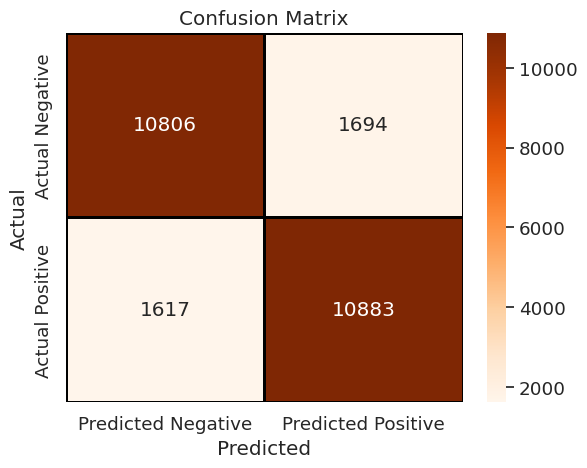

In [38]:
# Побудуємо confusion_matrix
confusion_mat = confusion_matrix(test_labels, binary_predictions)


# Використання Seaborn для візуалізації теплової карти
sns.set(font_scale=1.2)
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Oranges", linewidths=1, linecolor="black",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
wandb.finish()

epoch/accuracy,▁▅▇▇████
epoch/epoch,▁▂▃▄▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▂▂▁▁▁
epoch/val_accuracy,▁▆█▇▇▇▇▇
epoch/val_loss,▄▂▁▃▄▆▆█
epoch/accuracy,0.98634
epoch/epoch,7
epoch/learning_rate,0.001
epoch/loss,0.05372
epoch/val_accuracy,0.868


## Суб висновок: - валідаційні дані проходять з наступними показниками. Точність - 87.4% на валідації, час 75 хвилин, на тесті - 86.8%. n_epoch=15; lr=0,001; batch_size=128 Trainable params: 361,537


# Висновок

In [39]:
print("Результати тестів всіх побудованих моделей")
for item in best_of_models.items():
  print(item)

Результати тестів всіх побудованих моделей
('best_model_SimpleRNN', 0.8309999704360962)
('best_model_RNN_GRU', 0.85971999168396)
('best_model_RNN_LSTM', 0.8722000122070312)
('best_model_BRNN', 0.871399998664856)
('best_model_Deep_BRNN', 0.8675600290298462)


найкращою на цьому дата сеті із заданими параметрами: n_epoch=15; lr=0,001; batch_size=128 виявилася RNN_LSTM модель - 87,22% на тестовому наборі

#Спробуємо тест на реальних зразках

In [40]:
models = [best_model_SimpleRNN, best_model_RNN_GRU, best_model_RNN_LSTM, best_model_BRNN, best_model_Deep_BRNN]
model_names = ['best_model_SimpleRNN', 'best_model_RNN_GRU', 'best_model_RNN_LSTM', 'best_model_BRNN', 'best_model_Deep_BRNN']


# Список нових відгуків для перевірки
new_reviews = [
    "this movie was absolutely amazing!",
    "i didn't like this film at all. worst movie!",
    "the acting and storyline were both fantastic.",
    "terrible movie, waste of time.",
    "a must-watch for all movie lovers!",
    "I was blown away by how good this movie was.",
    "The direction and storytelling were not top-notch. waste",
    "This movie exceeded all my expectations. The performances were outstanding",
    "full shit",
]

# Мітки для нових відгуків
labels = [1, 0, 1, 0, 1, 1, 0, 1, 0]  # 1 - позитивний, 0 - негативний

# Токенізація та векторизація нових відгуків
new_reviews_tokenized = [[word_index.get(word, -2) + 3 for word in review.split(" ")] for review in new_reviews]
new_reviews_vector = pad_sequences(new_reviews_tokenized, maxlen=maxlen)

# Перевірка кожної моделі на нових відгуках
for model, model_name in zip(models, model_names):
    results = model.predict(new_reviews_vector)
    binary_results = [1 if result > 0.5 else 0 for result in results]
    correct_predictions = sum([1 for predicted, actual in zip(binary_results, labels) if predicted == actual])

    print(f"Results for {model_name}:")
    for review, binary_result in zip(new_reviews, binary_results):
        print(f"Review: '{review}' - Binary Result: {binary_result}")

    print(f"Correct predictions: {correct_predictions} out of {len(new_reviews)}\n")

1/1 [==============================] - 0s 66ms/step
Results for best_model_SimpleRNN:
Review: 'this movie was absolutely amazing!' - Binary Result: 0
Review: 'i didn't like this film at all. worst movie!' - Binary Result: 0
Review: 'the acting and storyline were both fantastic.' - Binary Result: 0
Review: 'terrible movie, waste of time.' - Binary Result: 0
Review: 'a must-watch for all movie lovers!' - Binary Result: 0
Review: 'I was blown away by how good this movie was.' - Binary Result: 0
Review: 'The direction and storytelling were not top-notch. waste' - Binary Result: 0
Review: 'This movie exceeded all my expectations. The performances were outstanding' - Binary Result: 1
Review: 'full shit' - Binary Result: 0
Correct predictions: 5 out of 9

1/1 [==============================] - 0s 40ms/step
Results for best_model_RNN_GRU:
Review: 'this movie was absolutely amazing!' - Binary Result: 1
Review: 'i didn't like this film at all. worst movie!' - Binary Result: 0
Review: 'the acting

### Після висновку - на нових сгенерованих відгуках тільки RNN_GRU (9 із 9), Deep_BRNN (8 із 9) та BRNN (7 із 9) показали результативність, інші дуже заоверфітилися, можна спробувати підбір параметрів моделей для їх поліпшення